In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy
import scipy.stats as stats

from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

import numpy as np
np.set_printoptions(precision=5, suppress=True)

# 1. Read in data and masks

In [73]:
(resid_map.values <= np.nanpercentile(resid_map, 5)) | (resid_map.values >= np.nanpercentile(resid_map, 95))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [89]:
# Heatmap
resid_map = pd.read_csv('../../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Masks for clients
#clients = np.loadtxt('../../../utils/analysis_utils/client_mask.csv').astype(bool)
#strong_clients = np.loadtxt('../../../utils/analysis_utils/strong_client_mask.csv').astype(bool)
clients = (resid_map.values <= np.nanpercentile(resid_map, 10)) | (resid_map.values >= np.nanpercentile(resid_map, 90))
mod_clients = (resid_map.values <= np.nanpercentile(resid_map, 5)) | (resid_map.values >= np.nanpercentile(resid_map, 95))
strong_clients = (resid_map.values <= np.nanpercentile(resid_map, 0.5)) | (resid_map.values >= np.nanpercentile(resid_map, 99.5))
ihb_clients = np.loadtxt('../../../utils/analysis_utils/inhibited_clients.csv').astype(bool)
dep_clients = np.loadtxt('../../../utils/analysis_utils/dependent_clients.csv').astype(bool)

# Masks for Cooks distance
cooks_clients = np.loadtxt('../../../utils/analysis_utils/cooks_d_client_idx.csv').astype(bool)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


# 2. Define different masks for each type of client

In [90]:
# Create inhibited and dependent masks using a general client mask
## 1 SD, 2 SD, Cook's distance

def create_ihb_dep_masks(curr_mask):
    mask = (resid_map * curr_mask.astype(int)).values
    mask[mask == 0.0] = np.nan
    mask = (~np.isnan(mask))

    # Pos/neg masks
    pos_resid_mask = resid_map.values > 0.0
    neg_resid_mask = resid_map.values < 0.0

    ihb_mask = mask & pos_resid_mask
    dep_mask = mask & neg_resid_mask
    
    return(ihb_mask, dep_mask)

ihb1, dep1 = create_ihb_dep_masks(clients)
ihb2, dep2 = create_ihb_dep_masks(mod_clients)
ihb3, dep3 = create_ihb_dep_masks(strong_clients)
ihb4, dep4 = create_ihb_dep_masks(cooks_clients)

masks = [
    (ihb1, dep1),
    (ihb2, dep2),
    (ihb3, dep3),
    (ihb4, dep4)
]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


# Percent client variants by position

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


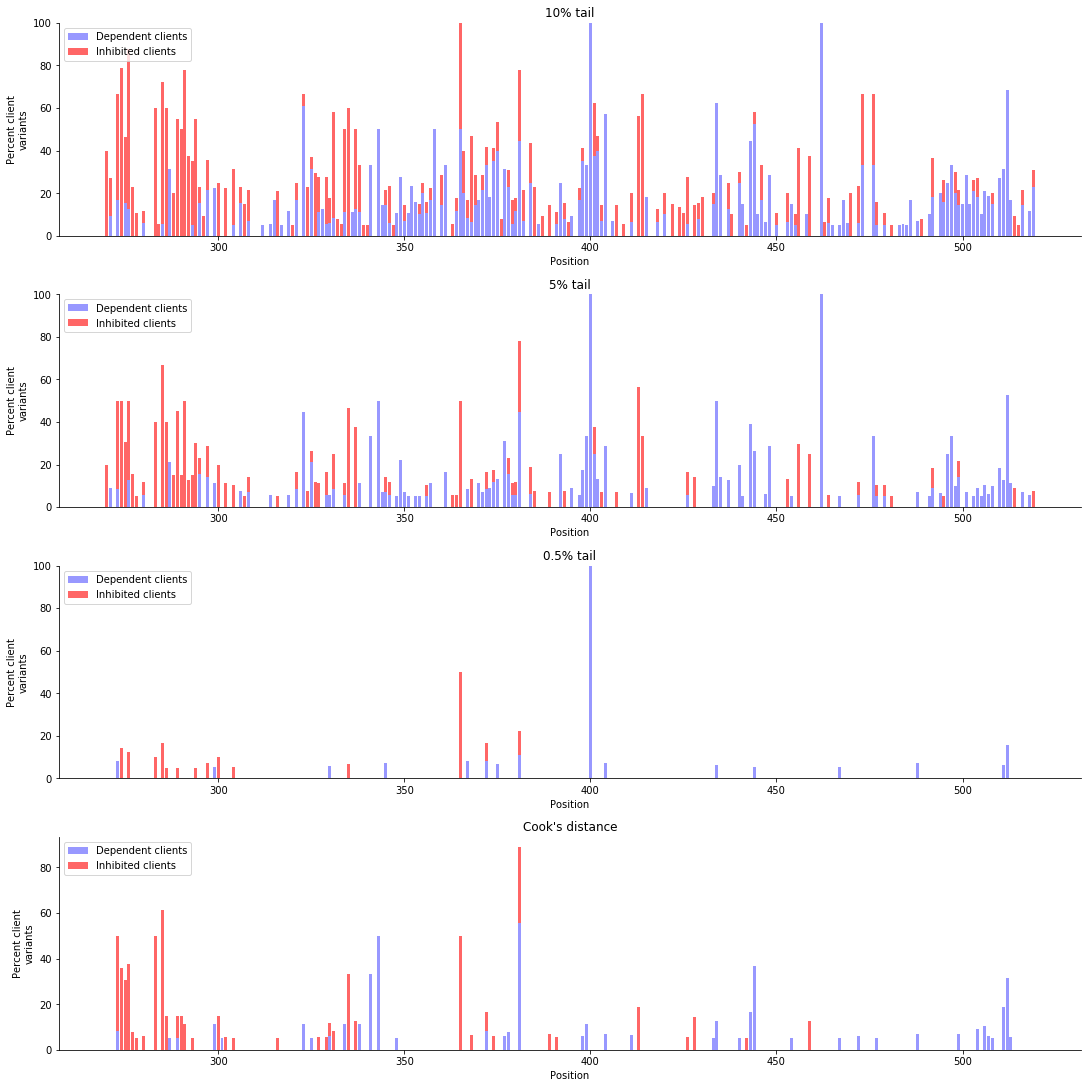

In [91]:
fig, ax = plt.subplots(4, 1, constrained_layout=True, figsize=(15, 15))
titles = ['10% tail', '5% tail', '0.5% tail', 'Cook\'s distance']

for idx, mask_tuple in enumerate(masks):
    ihb_client_mask = mask_tuple[0]
    dep_client_mask = mask_tuple[1]
    
    # Get number of inhibited and dependent
    num_dep = np.sum(dep_client_mask * 1, axis=1)
    num_ihb = np.sum(ihb_client_mask * 1, axis=1)
    num_mut = np.sum(~np.isnan(resid_map.values), axis=1)

    # Calculate percentage
    perc_dep = 100 * (num_dep / num_mut)
    perc_ihb = 100 * (num_ihb / num_mut)

    cmap = matplotlib.cm.get_cmap('bwr')
    dep = cmap(0.3)
    ihb = cmap(0.8)

    pos_arr = np.arange(270, 520)
    ax[idx].bar(pos_arr, perc_dep, color=dep, label='Dependent clients')
    ax[idx].bar(pos_arr, perc_ihb, color=ihb, bottom=perc_dep, label='Inhibited clients')
    ax[idx].set_xlabel('Position')
    ax[idx].set_ylabel('Percent client\nvariants')
    ax[idx].legend(loc=2)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['right'].set_visible(False)
    ax[idx].set_title(titles[idx])


# Percent inhibited - percent dependent

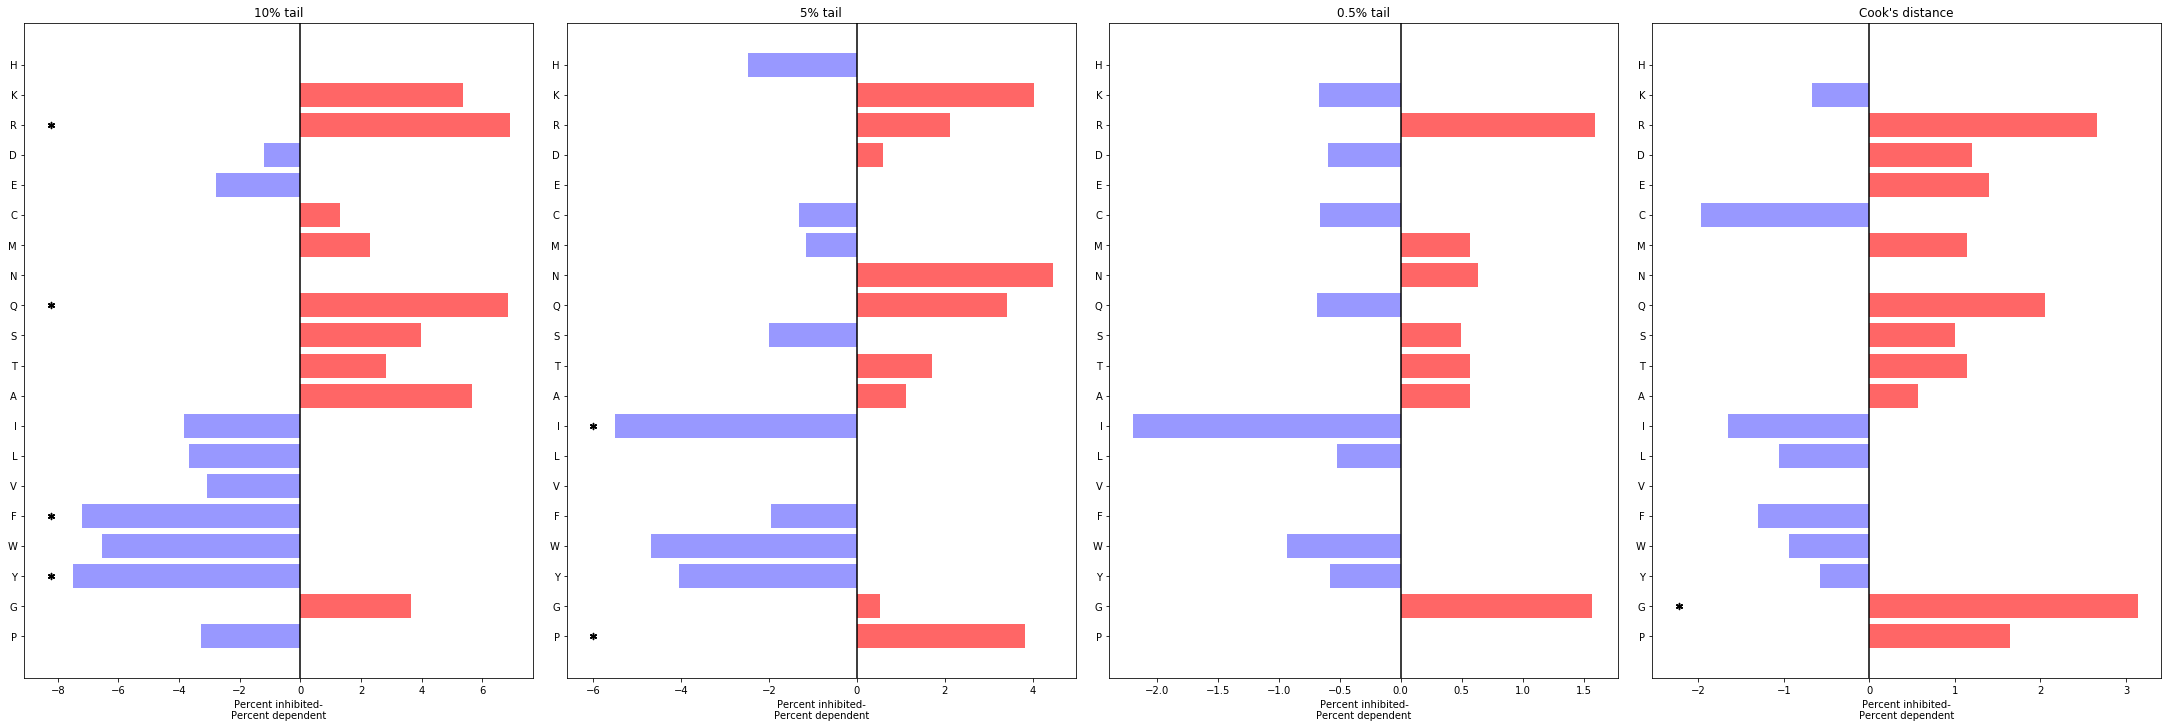

In [164]:
# Plot percent of amino acid mutations that are clients

# Dictionary for ticks
inv_aa_idx_dict = {v: k for k, v in src_utils.__aa_idx_dict__.items()}

# Set tick labels and locations
y_pos = list(inv_aa_idx_dict.keys())
tick_labels = inv_aa_idx_dict.values()


fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(30,10))

for idx, mask_tuple in enumerate(masks):
    
    # Unpack masks
    ihb_client_mask = mask_tuple[0]
    dep_client_mask = mask_tuple[1]
    
    # Count occurrences
    num_muts = np.sum(~np.isnan(resid_map.values), axis=0)
    num_dep = np.sum(dep_client_mask * 1, axis=0)
    num_ihb = np.sum(ihb_client_mask * 1, axis=0)

    # Calculate percentages
    perc_dep = 100 * (num_dep / num_muts)
    perc_ihb = 100 * (num_ihb / num_muts)
    
    # Calculate significance
    sig_aa = []
    for i, aa in enumerate(y_pos[:-1]):
    
        # Contingency table
        cont_table = np.array([[num_dep[i], num_ihb[i]],
                               [sum(num_dep) - num_dep[i], sum(num_ihb) - num_ihb[i]]])
        # Fisher's test
        _, p_val = scipy.stats.fisher_exact(cont_table)

        # If it is significant, record the amino acid
        alpha = 0.1
        if p_val < alpha:
            sig_aa.append(aa)

    # set height of bar
    diff = perc_ihb - perc_dep

    # Set color
    color_bars = []
    for val in diff:
        if val > 0:
            color_bars.append(ihb)
        else:
            color_bars.append(dep)

    # Plot bars
    ax[idx].barh(y_pos[:-1], diff[:-1], align='center', color=color_bars)
    ax[idx].axvline(0, c='k')
    
    # Plot asterisks for significance
    x_sig = [ax[idx].get_xlim()[0]] * len(sig_aa)
    ax[idx].scatter(x_sig, sig_aa, marker=(6,2,0), c='k')

    # Relabel ticks
    ax[idx].set_yticks(y_pos[:-1])
    ax[idx].set_yticklabels(list(tick_labels)[:-1])
    ax[idx].invert_yaxis()  # labels read top-to-bottom

    #ax[idx].set_xlim([-9, 9])

    # Label axes
    ax[idx].set_xlabel('Percent inhibited-\nPercent dependent') 
    
    # Title
    ax[idx].set_title(titles[idx])


# Cluster percents

In [168]:
# Fill with 0s and generate the linkage matrix
X = resid_map.fillna(0.0)
Z = linkage(X, 'ward')

clusters = fcluster(Z, 8, criterion='maxclust')

# Create cluster dictionary with key=cluster, val=idx
clust_dict = {}
for cluster in np.arange(1, max(clusters) + 1):
    clust_dict[cluster] = np.argwhere(clusters == cluster).flatten()
    
# Get cluster positions
clust1 = np.concatenate((clust_dict[1], clust_dict[2], clust_dict[3]))
clust2 = np.concatenate((clust_dict[4], clust_dict[5]))
clust3 = np.concatenate((clust_dict[6], clust_dict[7], clust_dict[8]))

# Get all mutations for that position
clust1_vals = resid_map.values[clust1, :]
clust2_vals = resid_map.values[clust2, :]
clust3_vals = resid_map.values[clust3, :]

In [178]:
# Generate cluster masks
clust1_mask = np.zeros((250, 21))
clust2_mask = np.zeros((250, 21))
clust3_mask = np.zeros((250, 21))

clust1_mask[clust1] = 1
clust2_mask[clust2] = 1
clust3_mask[clust3] = 1

clust1_mask = clust1_mask.astype(bool)
clust2_mask = clust2_mask.astype(bool)
clust3_mask = clust3_mask.astype(bool)

In [187]:
mask[0] & clust1_mask

NameError: name 'clust_mask' is not defined

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


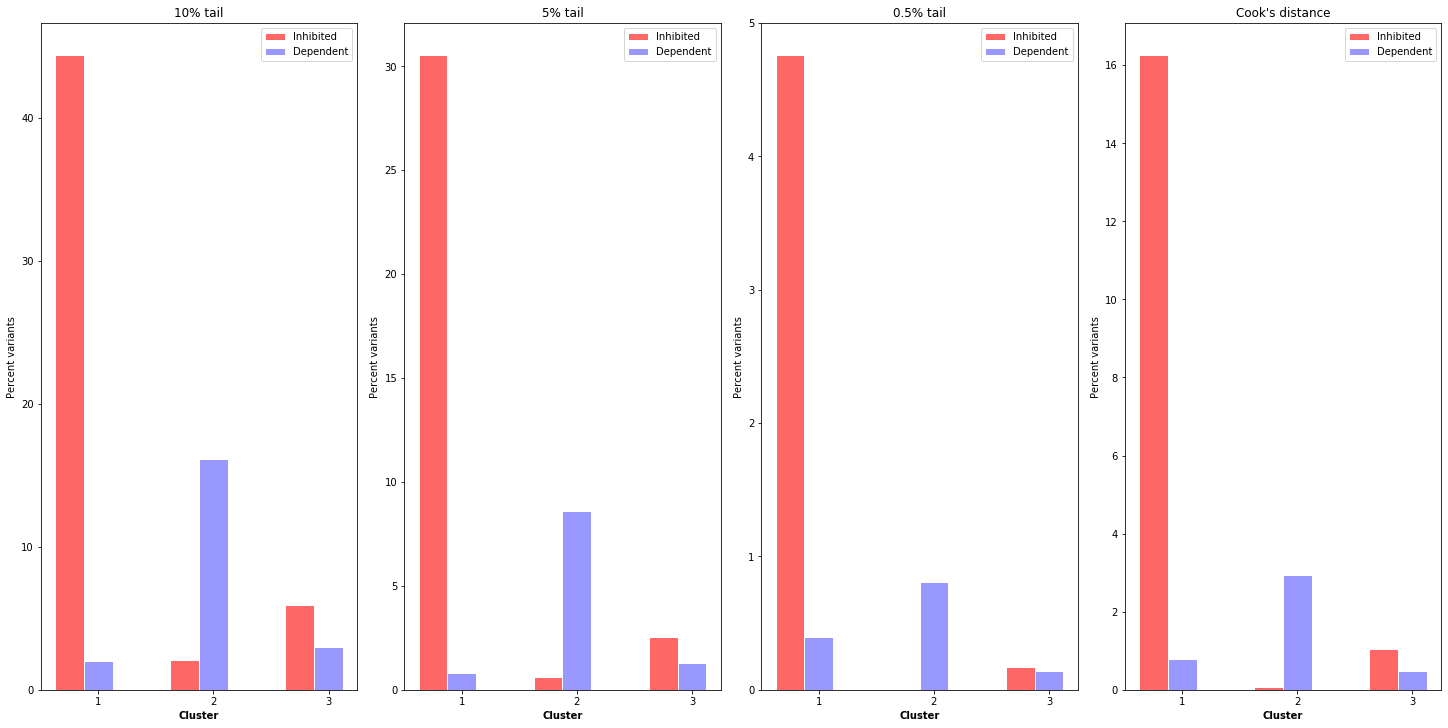

In [189]:
def get_variant_classification(clust_mask, client_mask):
    
    # Pos/neg masks
    pos_resid_mask = resid_map.values > 0.0
    neg_resid_mask = resid_map.values < 0.0
    
    n = np.sum(clust_mask)
    num_ihb = np.sum(clust_mask & client_mask[0])
    num_dep = np.sum(clust_mask & client_mask[1])
    num_non = n - num_ihb - num_dep
    
    return(num_ihb, num_dep, num_non)

fig, ax = plt.subplots(1,4, constrained_layout=True, figsize=(20,10))
for idx, mask in enumerate(masks):
    
    # Get variant classifications
    c1_ihb, c1_dep, c1_non = get_variant_classification(clust1_mask, mask)
    c2_ihb, c2_dep, c2_non = get_variant_classification(clust2_mask, mask)
    c3_ihb, c3_dep, c3_non = get_variant_classification(clust3_mask, mask)

    # set width of bar
    barWidth = 0.25

    # set height of bar
    totals = np.array([c1_ihb + c1_dep + c1_non, c2_ihb + c2_dep + c2_non, c3_ihb + c3_dep + c3_non])
    bars1 = 100 * (np.array([c1_ihb, c2_ihb, c3_ihb]) / totals)
    bars2 = 100 * (np.array([c1_dep, c2_dep, c3_dep]) / totals)

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    ax[idx].bar(r1, bars1, color=ihb, width=barWidth, edgecolor='white', label='Inhibited')
    ax[idx].bar(r2, bars2, color=dep, width=barWidth, edgecolor='white', label='Dependent')

    # Add xticks on the middle of the group bars
    ax[idx].set_xlabel('Cluster', fontweight='bold')
    ax[idx].set_xticks([r + barWidth for r in range(len(bars1))])
    ax[idx].set_xticklabels(['1', '2', '3'])
    ax[idx].set_ylabel('Percent variants')

    # Create legend & Show graphic
    ax[idx].legend()
    
    # Title
    ax[idx].set_title(titles[idx])